In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '50 percent More buy LSTM Time Series - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0
(207, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0
(207, 15, 4)
            previous_1d     EMA_12  

In [6]:
r_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0
(208, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0
(208, 15, 4)
            previous_1d      EMA_12 

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


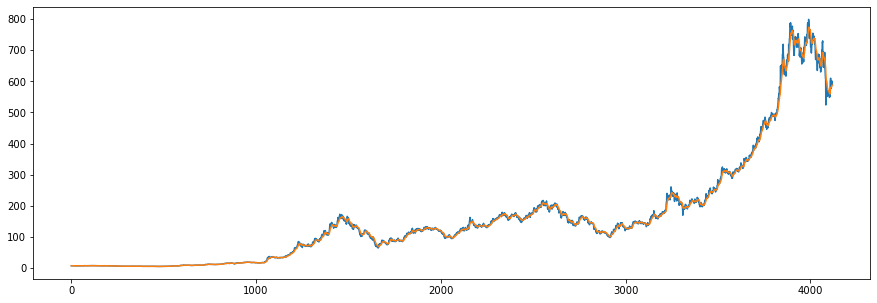

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


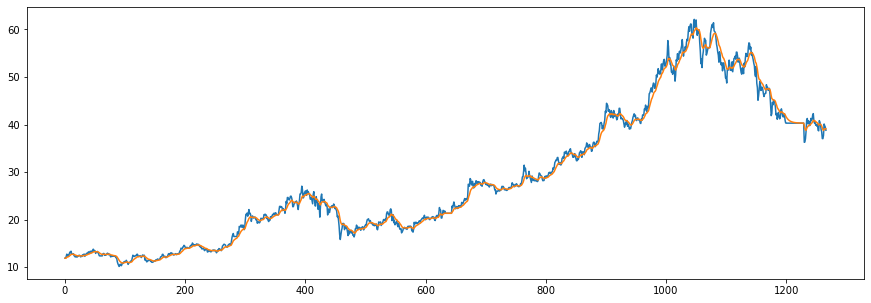

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


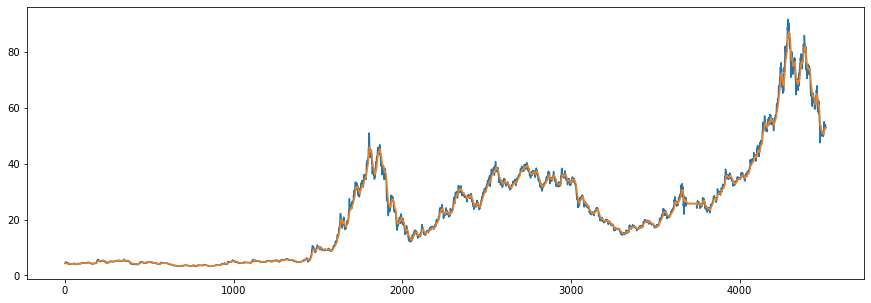

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


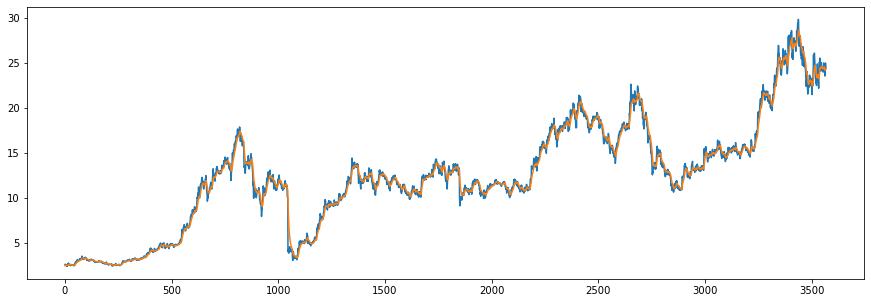

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      50.0000  47.379245 -27.700831  21139400.0     2.0
2000-01-24      48.5000  47.551669 -40.997230  17619200.0     2.0
2000-01-25      47.0000  47.466797 -54.293629  12613700.0     2.0
2000-01-26      49.6875  47.808444 -30.470914  16344500.0     2.0
2000-01-27      50.4375  48.212914 -27.215190  20127300.0     2.0


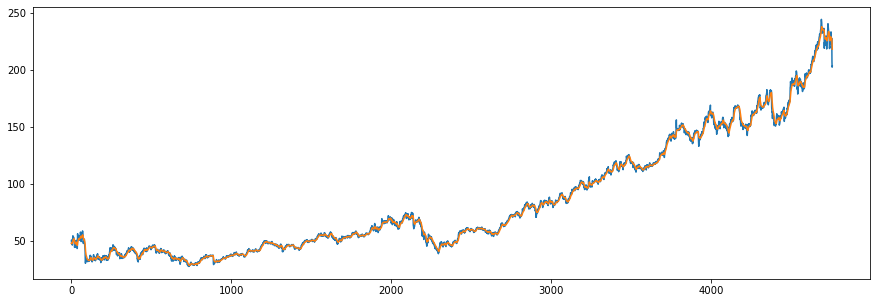

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21     56.28125  56.412106 -36.614173 -25968400.0     2.0
2000-01-24     51.34375  55.632359 -83.112583 -50347200.0     2.0
2000-01-25     51.56250  55.006226 -64.721485 -21792600.0     1.0
2000-01-26     48.75000  54.043730 -88.594164 -38890400.0     2.0
2000-01-27     50.31250  53.469695 -75.331565 -28647200.0     2.0


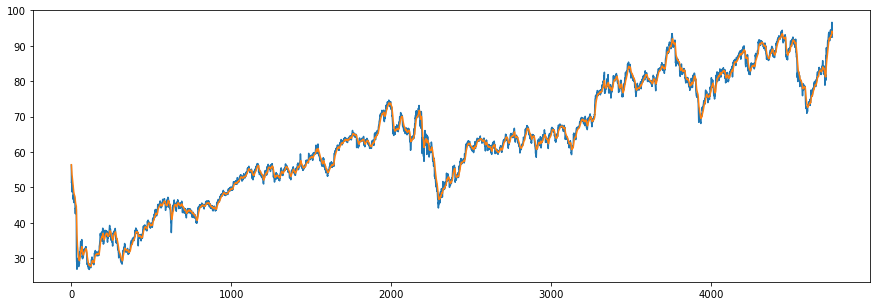

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


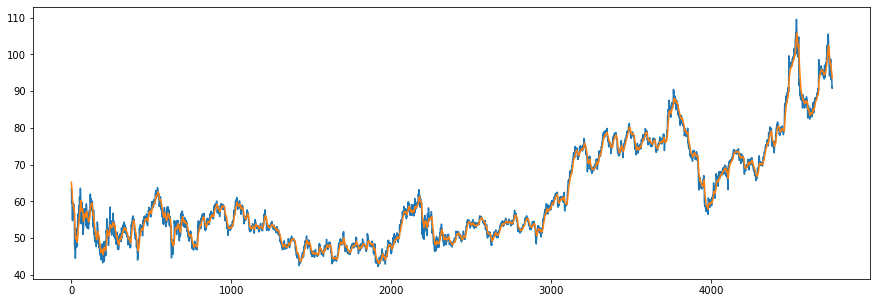

In [10]:
labels = []
sequential = []

train_sets = ['600519.SS','000333.SZ','000858.SZ','2319.HK','COST','PG','WMT']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(27645, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(27645,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 25128, 1.0: 1252, 0.0: 1265})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:626]
class_1 = class_1[0:1252]
class_2 = class_2[0:626]

class_0_labels = class_0_labels[0:626]
class_1_labels = class_1_labels[0:1252]
class_2_labels = class_2_labels[0:626]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(2504, 15, 4)


Counter({0.0: 626, 1.0: 1252, 2.0: 626})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600519.SS','000333.SZ','WMT','FDP']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 ... 1 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/16 [>.............................] - ETA: 0s - loss: 0.3674 - accuracy: 0.3438 - mse: 0.4466 - weighted_accuracy: 0.3641 - weighted_mse: 0.4291WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
16/16 [==============================] - 1s 79ms/step - loss: 0.3059 - accuracy: 0.3275 - mse: 0.4801 - weighted_accuracy: 0.3334 - weighted_mse: 0.4784 - val_loss: 0.3004 - val_accuracy: 0.3852 - val_mse: 0.3428 - val_weighted_accuracy: 0.3852 - val_weighted_mse: 0.3428
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 0.2261 - accuracy: 0.4578 - mse: 0.6151 - weighted_accuracy: 0.4469 - weighted_mse: 0.6255 - val_loss: 0.2950 - val_accuracy: 0.5010 - val_mse: 0.3486 - val_weighted_accuracy: 0.5

7/7 [==============================] - 0s 3ms/step - loss: 0.2211 - accuracy: 0.0625 - mse: 0.9770 - weighted_accuracy: 0.0625 - weighted_mse: 0.9770
Test loss: 0.22113822400569916
Test accuracy: 0.0625


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 7
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 147
actual holds but predicted sell: 41
actual predicted holds: 1
Percentage buys correct: 5.521472392638037%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 100.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 42.592592592592595%
Percentage high sells correct: 43.18181818181818%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.14442053980990632
Shares owned at the moment: 690
Cash capital at the moment: $0.0757895568753355


Price increase from previously bought: -2

Share price: $0.3323767284493312
Shares owned at the moment: 521
Cash capital at the moment: $0.2804473250353965


Price increase from previously bought: 63.51392782881573%
Share price: $0.5449768200470785
Shares owned at the moment: 0
Cash capital at the moment: $283.43255503064086


Share price: $0.5156890110192186
Shares owned at the moment: 548
Cash capital at the moment: $0.057833652503063604


Price increase from previously bought: 1.192635448215107%
Share price: $0.5232743590448435
Shares owned at the moment: 0
Cash capital at the moment: $286.02360794999674


Share price: $0.5601475160983284
Shares owned at the moment: 509
Cash capital at the moment: $0.12445577028898924


Price increase from previously bought: 4.4523500419444195%
Share price: $0.5866962341880152
Shares owned at the moment: 0
Cash capital at the moment: $297.93161091818405


Share price: $0.6612852218496476
Shares owned at the moment: 449
Cash capital at the moment: $0.1980243800134076


Price increase from pre

7/7 [==============================] - 0s 3ms/step - loss: 0.2286 - accuracy: 0.0872 - mse: 1.0073 - weighted_accuracy: 0.0872 - weighted_mse: 1.0073
Test loss: 0.22863048315048218
Test accuracy: 0.08715596050024033


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 7
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 149
actual holds but predicted sell: 42
actual predicted holds: 7
Percentage buys correct: 5.454545454545454%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 32.926829268292686%
Percentage high sells correct: 37.77777777777778%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from previousl

16/16 [==============================] - 1s 88ms/step - loss: 0.1393 - accuracy: 0.7369 - mse: 1.3618 - weighted_accuracy: 0.7082 - weighted_mse: 1.3797 - val_loss: 0.1843 - val_accuracy: 0.5250 - val_mse: 0.9523 - val_weighted_accuracy: 0.5250 - val_weighted_mse: 0.9523
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1373 - accuracy: 0.7334 - mse: 1.3754 - weighted_accuracy: 0.7105 - weighted_mse: 1.3930 - val_loss: 0.1826 - val_accuracy: 0.5329 - val_mse: 0.9958 - val_weighted_accuracy: 0.5329 - val_weighted_mse: 0.9958
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1363 - accuracy: 0.7419 - mse: 1.3834 - weighted_accuracy: 0.7182 - weighted_mse: 1.4009 - val_loss: 0.1805 - val_accuracy: 0.5409 - val_mse: 1.0400 - val_weighted_accuracy: 0.5409 - val_weighted_mse: 1.0400
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1340 - accuracy: 0.7499 - mse: 1.3850 - weighted_accuracy: 0.7291 - weighted_mse: 1.405

7/7 [==============================] - 0s 3ms/step - loss: 0.2830 - accuracy: 0.1875 - mse: 1.7533 - weighted_accuracy: 0.1875 - weighted_mse: 1.7533
Test loss: 0.28301551938056946
Test accuracy: 0.1875


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 62
actual holds but predicted sell: 104
actual predicted holds: 23
Percentage buys correct: 11.267605633802816%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 92.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.929577464788736%
Percentage high sells correct: 53.153153153153156%
Percentage mid holds correct: 88.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought:

7/7 [==============================] - 0s 4ms/step - loss: 0.2668 - accuracy: 0.1442 - mse: 1.7052 - weighted_accuracy: 0.1442 - weighted_mse: 1.7052
Test loss: 0.2668231427669525
Test accuracy: 0.14423076808452606


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 99
actual predicted holds: 18
Percentage buys correct: 7.228915662650603%
Percentage sells correct: 5.714285714285714%
Percentage holds correct: 90.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.42168674698795%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.17308466104252018
Shares owned at the moment: 576
Cash capital at the moment: $0.02906913641702147


Price increase from previously bought: 1.5467

7/7 [==============================] - 0s 3ms/step - loss: 0.2638 - accuracy: 0.2100 - mse: 1.6723 - weighted_accuracy: 0.2100 - weighted_mse: 1.6723
Test loss: 0.2637958228588104
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 107
actual holds but predicted sell: 61
actual predicted holds: 33
Percentage buys correct: 5.217391304347826%
Percentage sells correct: 10.294117647058824%
Percentage holds correct: 91.66666666666667%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 55.88235294117647%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase fr

7/7 [==============================] - 0s 4ms/step - loss: 0.2859 - accuracy: 0.1872 - mse: 1.7350 - weighted_accuracy: 0.1872 - weighted_mse: 1.7350
Test loss: 0.2859409749507904
Test accuracy: 0.18721461296081543


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 92
actual holds but predicted sell: 80
actual predicted holds: 27
Percentage buys correct: 6.862745098039215%
Percentage sells correct: 7.954545454545454%
Percentage holds correct: 93.10344827586206%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 53.46534653465346%
Percentage high sells correct: 52.27272727272727%
Percentage mid holds correct: 86.20689655172414%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

16/16 [==============================] - 0s 11ms/step - loss: 0.1089 - accuracy: 0.8053 - mse: 1.6895 - weighted_accuracy: 0.7917 - weighted_mse: 1.7119 - val_loss: 0.1361 - val_accuracy: 0.7046 - val_mse: 1.5576 - val_weighted_accuracy: 0.7046 - val_weighted_mse: 1.5576
Epoch 7/20
16/16 [==============================] - 0s 12ms/step - loss: 0.1086 - accuracy: 0.8048 - mse: 1.6945 - weighted_accuracy: 0.7877 - weighted_mse: 1.7160 - val_loss: 0.1358 - val_accuracy: 0.7146 - val_mse: 1.6143 - val_weighted_accuracy: 0.7146 - val_weighted_mse: 1.6143
Epoch 8/20
16/16 [==============================] - 0s 11ms/step - loss: 0.1065 - accuracy: 0.8103 - mse: 1.7093 - weighted_accuracy: 0.7954 - weighted_mse: 1.7280 - val_loss: 0.1345 - val_accuracy: 0.7166 - val_mse: 1.5879 - val_weighted_accuracy: 0.7166 - val_weighted_mse: 1.5879
Epoch 9/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1070 - accuracy: 0.8143 - mse: 1.7375 - weighted_accuracy: 0.8013 - weighted_mse: 1.756

7/7 [==============================] - 0s 4ms/step - loss: 0.3750 - accuracy: 0.1827 - mse: 2.4754 - weighted_accuracy: 0.1827 - weighted_mse: 2.4754
Test loss: 0.3750496208667755
Test accuracy: 0.18269230425357819


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 60
actual holds but predicted sell: 104
actual predicted holds: 25
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 6.25%
Percentage holds correct: 89.28571428571429%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 74.07407407407408%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 14.

7/7 [==============================] - 0s 3ms/step - loss: 0.3417 - accuracy: 0.2019 - mse: 2.3713 - weighted_accuracy: 0.2019 - weighted_mse: 2.3713
Test loss: 0.34172090888023376
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 65
actual holds but predicted sell: 97
actual predicted holds: 31
Percentage buys correct: 7.042253521126761%
Percentage sells correct: 5.825242718446602%
Percentage holds correct: 91.17647058823529%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 54.929577464788736%
Percentage high sells correct: 50.48543689320388%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.1853055173898276
Shares owned at the moment: 538
Cash capital at the moment: $0.031472131294492556


Pric

Price increase from previously bought: 15.722282455660054%
Share price: $0.25960134287068404
Shares owned at the moment: 0
Cash capital at the moment: $185.96301880051217


Share price: $0.14317399216253146
Shares owned at the moment: 1295
Cash capital at the moment: $0.04282057044511589


Price increase from previously bought: 36.38550102004161%
Share price: $0.19580555509925213
Shares owned at the moment: 0
Cash capital at the moment: $252.9137018908794


Share price: $0.2488359272664431
Shares owned at the moment: 1013
Cash capital at the moment: $0.14971288559004847


Price increase from previously bought: 61.56683879392697%
Share price: $0.40314194140698434
Shares owned at the moment: 0
Cash capital at the moment: $407.40944686759065


Share price: $0.5889474965062365
Shares owned at the moment: 689
Cash capital at the moment: $0.5087135057885348


Price increase from previously bought: 10.528216341999075%
Share price: $0.6527432842776684
Shares owned at the moment: 0
Cash capital

7/7 [==============================] - 0s 4ms/step - loss: 0.3456 - accuracy: 0.2982 - mse: 2.4486 - weighted_accuracy: 0.2982 - weighted_mse: 2.4486
Test loss: 0.34564027190208435
Test accuracy: 0.29816514253616333


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 74
actual holds but predicted sell: 75
actual predicted holds: 49
Percentage buys correct: 8.641975308641975%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 92.45283018867924%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 53.08641975308642%
Percentage high sells correct: 50.602409638554214%
Percentage mid holds correct: 81.13207547169812%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Pr

Epoch 1/20
16/16 [==============================] - 0s 20ms/step - loss: 0.0950 - accuracy: 0.8407 - mse: 1.9138 - weighted_accuracy: 0.8336 - weighted_mse: 1.9314 - val_loss: 0.1348 - val_accuracy: 0.7106 - val_mse: 1.8893 - val_weighted_accuracy: 0.7106 - val_weighted_mse: 1.8893
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 0.0942 - accuracy: 0.8323 - mse: 1.9463 - weighted_accuracy: 0.8240 - weighted_mse: 1.9577 - val_loss: 0.1360 - val_accuracy: 0.6966 - val_mse: 1.9900 - val_weighted_accuracy: 0.6966 - val_weighted_mse: 1.9900
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0925 - accuracy: 0.8437 - mse: 1.9386 - weighted_accuracy: 0.8393 - weighted_mse: 1.9501 - val_loss: 0.1365 - val_accuracy: 0.7126 - val_mse: 1.9287 - val_weighted_accuracy: 0.7126 - val_weighted_mse: 1.9287
Epoch 4/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0911 - accuracy: 0.8507 - mse: 1.9453 - weighted_accuracy: 0.8443 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.4840 - accuracy: 0.2019 - mse: 3.1326 - weighted_accuracy: 0.2019 - weighted_mse: 3.1326
Test loss: 0.4839636981487274
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 60
actual holds but predicted sell: 100
actual predicted holds: 29
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 6.422018348623853%
Percentage holds correct: 93.54838709677419%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 50.0%
Percentage high sells correct: 49.54128440366973%
Percentage mid holds correct: 76.66666666666667%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.4536 - accuracy: 0.1923 - mse: 3.0443 - weighted_accuracy: 0.1923 - weighted_mse: 3.0443
Test loss: 0.4535576403141022
Test accuracy: 0.19230769574642181


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 72
actual holds but predicted sell: 93
actual predicted holds: 28
Percentage buys correct: 6.4935064935064934%
Percentage sells correct: 7.0%
Percentage holds correct: 90.3225806451613%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 52.0%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.1853055173898276
Shares owned at the moment: 538
Cash capital at the moment: $0.031472131294492556


Price increase from previously bo


Price increase from previously bought: -2.9684544160769932%
Share price: $0.08615644029755808
Shares owned at the moment: 0
Cash capital at the moment: $155.9406845364478


Share price: $0.2839235344901534
Shares owned at the moment: 547
Cash capital at the moment: $0.20741919357706706


Price increase from previously bought: 6.167971034694242%
Share price: $0.30226480446179615
Shares owned at the moment: 0
Cash capital at the moment: $165.0915854020679


Share price: $0.22371611718603135
Shares owned at the moment: 735
Cash capital at the moment: $0.20805306847256588


Price increase from previously bought: 15.722282455660054%
Share price: $0.25960134287068404
Shares owned at the moment: 0
Cash capital at the moment: $190.49032086414795


Share price: $0.14317399216253146
Shares owned at the moment: 1326
Cash capital at the moment: $0.11952329421055197


Price increase from previously bought: 36.38550102004161%
Share price: $0.19580555509925213
Shares owned at the moment: 0
Cash capi

7/7 [==============================] - 0s 3ms/step - loss: 0.4737 - accuracy: 0.2477 - mse: 3.2539 - weighted_accuracy: 0.2477 - weighted_mse: 3.2539
Test loss: 0.4737047255039215
Test accuracy: 0.24770642817020416


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 86
actual holds but predicted sell: 74
actual predicted holds: 38
Percentage buys correct: 7.526881720430108%
Percentage sells correct: 10.843373493975903%
Percentage holds correct: 90.47619047619048%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 78.57142857142857%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase fr

Share price: $0.21138447845289887
Shares owned at the moment: 225
Cash capital at the moment: $0.06604297227592326


Price increase from previously bought: -18.682022953405863%
Share price: $0.17236628901797912
Shares owned at the moment: 0
Cash capital at the moment: $38.74180635999135


Share price: $0.2038326250294833
Shares owned at the moment: 189
Cash capital at the moment: $0.11149822255993769


Price increase from previously bought: 23.126167394592745%
Share price: $0.2516614701711153
Shares owned at the moment: 0
Cash capital at the moment: $47.54471503577929


Share price: $0.11572678816963532
Shares owned at the moment: 409
Cash capital at the moment: $0.08229496940464998


Price increase from previously bought: 36.06069464915844%
Share price: $0.15789168322643254
Shares owned at the moment: 0
Cash capital at the moment: $64.48240473830663


Share price: $0.19502196932277105
Shares owned at the moment: 329
Cash capital at the moment: $0.14373070437017077


Price increase fro

16/16 [==============================] - 0s 10ms/step - loss: 0.0684 - accuracy: 0.8892 - mse: 2.5407 - weighted_accuracy: 0.8918 - weighted_mse: 2.5421 - val_loss: 0.1469 - val_accuracy: 0.7246 - val_mse: 2.7187 - val_weighted_accuracy: 0.7246 - val_weighted_mse: 2.7187
Epoch 14/20
16/16 [==============================] - 0s 11ms/step - loss: 0.0681 - accuracy: 0.8947 - mse: 2.5688 - weighted_accuracy: 0.8935 - weighted_mse: 2.5601 - val_loss: 0.1514 - val_accuracy: 0.7166 - val_mse: 2.7528 - val_weighted_accuracy: 0.7166 - val_weighted_mse: 2.7528
Epoch 15/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0667 - accuracy: 0.8992 - mse: 2.6003 - weighted_accuracy: 0.9002 - weighted_mse: 2.5905 - val_loss: 0.1481 - val_accuracy: 0.7186 - val_mse: 2.8967 - val_weighted_accuracy: 0.7186 - val_weighted_mse: 2.8967
Epoch 16/20
16/16 [==============================] - 0s 13ms/step - loss: 0.0647 - accuracy: 0.9006 - mse: 2.6566 - weighted_accuracy: 0.8985 - weighted_mse: 2.

7/7 [==============================] - 0s 4ms/step - loss: 0.5406 - accuracy: 0.2308 - mse: 3.6039 - weighted_accuracy: 0.2308 - weighted_mse: 3.6039
Test loss: 0.5405935645103455
Test accuracy: 0.23076923191547394


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 58
actual holds but predicted sell: 95
actual predicted holds: 36
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 50.0%
Percentage high sells correct: 49.01960784313726%
Percentage mid holds correct: 76.92307692307692%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously

7/7 [==============================] - 0s 4ms/step - loss: 0.4989 - accuracy: 0.2163 - mse: 3.5038 - weighted_accuracy: 0.2163 - weighted_mse: 3.5038
Test loss: 0.4989226460456848
Test accuracy: 0.2163461595773697


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 75
actual holds but predicted sell: 84
actual predicted holds: 34
Percentage buys correct: 6.25%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 89.47368421052632%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.25%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 81.08108108108108%


Capital: 100
Share price: $0.1853055173898276
Shares owned at the moment: 538
Cash capital at the moment: $0.031472131294492556


Price increase from previously 

7/7 [==============================] - 0s 4ms/step - loss: 0.5450 - accuracy: 0.2785 - mse: 3.5436 - weighted_accuracy: 0.2785 - weighted_mse: 3.5436
Test loss: 0.5449895858764648
Test accuracy: 0.2785388231277466


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 90
actual holds but predicted sell: 63
actual predicted holds: 48
Percentage buys correct: 5.208333333333333%
Percentage sells correct: 11.267605633802816%
Percentage holds correct: 92.3076923076923%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.473684210526315%
Percentage high sells correct: 52.11267605633803%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.5578 - accuracy: 0.2648 - mse: 3.8089 - weighted_accuracy: 0.2648 - weighted_mse: 3.8089
Test loss: 0.5577986836433411
Test accuracy: 0.26484018564224243


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 81
actual holds but predicted sell: 73
actual predicted holds: 45
Percentage buys correct: 7.777777777777778%
Percentage sells correct: 7.5%
Percentage holds correct: 91.83673469387755%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.68539325842696%
Percentage high sells correct: 47.5%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bou

16/16 [==============================] - 0s 10ms/step - loss: 0.0638 - accuracy: 0.9011 - mse: 2.8079 - weighted_accuracy: 0.9038 - weighted_mse: 2.7863 - val_loss: 0.1494 - val_accuracy: 0.7305 - val_mse: 2.8651 - val_weighted_accuracy: 0.7305 - val_weighted_mse: 2.8651
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0616 - accuracy: 0.9076 - mse: 2.7816 - weighted_accuracy: 0.9085 - weighted_mse: 2.7641 - val_loss: 0.1486 - val_accuracy: 0.7345 - val_mse: 2.8539 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 2.8539
Epoch 4/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0598 - accuracy: 0.9086 - mse: 2.7904 - weighted_accuracy: 0.9115 - weighted_mse: 2.7733 - val_loss: 0.1531 - val_accuracy: 0.7345 - val_mse: 2.9521 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 2.9521
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0620 - accuracy: 0.9046 - mse: 2.8743 - weighted_accuracy: 0.9048 - weighted_mse: 2.846

7/7 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.2115 - mse: 4.4139 - weighted_accuracy: 0.2115 - weighted_mse: 4.4139
Test loss: 0.6813125610351562
Test accuracy: 0.21153846383094788


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 61
actual holds but predicted sell: 97
actual predicted holds: 31
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 93.93939393939394%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 48.57142857142857%
Percentage high sells correct: 49.523809523809526%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase 



Price increase from previously bought: 55.99824172021788%
Share price: $0.6565215080037607
Shares owned at the moment: 0
Cash capital at the moment: $9244.64659023064


Share price: $0.5925721139991345
Shares owned at the moment: 15558
Cash capital at the moment: $0.0567390207106655


Price increase from previously bought: 8.83222425502912%
Share price: $0.6466829128632507
Shares owned at the moment: 0
Cash capital at the moment: $10033.481492261768


Share price: $0.5096486886207019
Shares owned at the moment: 19633
Cash capital at the moment: $0.032473636380018434


Price increase from previously bought: 9.763914320633237%
Share price: $0.5609487283761212
Shares owned at the moment: 0
Cash capital at the moment: $10982.852815288194


Share price: $0.5117568249708
Shares owned at the moment: 21402
Cash capital at the moment: $0.11354345106155961


Price increase from previously bought: -17.939863149804125%
Share price: $0.42110320887626185
Shares owned at the moment: 0
Cash capital 

7/7 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.1972 - mse: 4.5874 - weighted_accuracy: 0.1972 - weighted_mse: 4.5874
Test loss: 0.7123130559921265
Test accuracy: 0.197247713804245


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 80
actual holds but predicted sell: 90
actual predicted holds: 32
Percentage buys correct: 5.813953488372093%
Percentage sells correct: 6.25%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase from previously bought: 12.096

7/7 [==============================] - 0s 4ms/step - loss: 0.7213 - accuracy: 0.2294 - mse: 4.8974 - weighted_accuracy: 0.2294 - weighted_mse: 4.8974
Test loss: 0.7212966680526733
Test accuracy: 0.2293577939271927


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 89
actual holds but predicted sell: 75
actual predicted holds: 34
Percentage buys correct: 7.291666666666667%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 89.47368421052632%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.602409638554214%
Percentage mid holds correct: 81.57894736842105%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase fr

Epoch 1/20
16/16 [==============================] - 0s 19ms/step - loss: 0.0508 - accuracy: 0.9296 - mse: 3.3955 - weighted_accuracy: 0.9304 - weighted_mse: 3.3360 - val_loss: 0.1717 - val_accuracy: 0.7246 - val_mse: 3.4954 - val_weighted_accuracy: 0.7246 - val_weighted_mse: 3.4954
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0506 - accuracy: 0.9296 - mse: 3.4478 - weighted_accuracy: 0.9324 - weighted_mse: 3.3944 - val_loss: 0.1655 - val_accuracy: 0.7365 - val_mse: 3.5630 - val_weighted_accuracy: 0.7365 - val_weighted_mse: 3.5630
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0493 - accuracy: 0.9341 - mse: 3.4049 - weighted_accuracy: 0.9351 - weighted_mse: 3.3564 - val_loss: 0.1626 - val_accuracy: 0.7405 - val_mse: 3.5662 - val_weighted_accuracy: 0.7405 - val_weighted_mse: 3.5662
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0477 - accuracy: 0.9331 - mse: 3.4324 - weighted_accuracy: 0.9361 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.8148 - accuracy: 0.2212 - mse: 5.3252 - weighted_accuracy: 0.2212 - weighted_mse: 5.3252
Test loss: 0.8147546052932739
Test accuracy: 0.2211538404226303


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 59
actual holds but predicted sell: 97
actual predicted holds: 33
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 94.28571428571429%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 48.529411764705884%
Percentage high sells correct: 48.57142857142857%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.2596 - mse: 4.9941 - weighted_accuracy: 0.2596 - weighted_mse: 4.9941
Test loss: 0.7295729517936707
Test accuracy: 0.25961539149284363


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 65
actual holds but predicted sell: 84
actual predicted holds: 44
Percentage buys correct: 5.797101449275362%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 89.79591836734694%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 60.869565217391305%
Percentage high sells correct: 53.93258426966292%
Percentage mid holds correct: 79.59183673469387%


Capital: 100
Share price: $0.1853055173898276
Shares owned at the moment: 538
Cash capital at the moment: $0.031472131294492556


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.8102 - accuracy: 0.2283 - mse: 5.2092 - weighted_accuracy: 0.2283 - weighted_mse: 5.2092
Test loss: 0.810238242149353
Test accuracy: 0.2283104956150055


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 101
actual holds but predicted sell: 64
actual predicted holds: 36
Percentage buys correct: 4.672897196261682%
Percentage sells correct: 12.32876712328767%
Percentage holds correct: 92.3076923076923%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.68493150684932%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.2521008983715609
Shares owned at the moment: 395
Cash capital at the moment: $0.14630054237733248


Price increase from p

7/7 [==============================] - 0s 3ms/step - loss: 0.8337 - accuracy: 0.2603 - mse: 5.7194 - weighted_accuracy: 0.2603 - weighted_mse: 5.7194
Test loss: 0.8336713910102844
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 79
actual holds but predicted sell: 76
actual predicted holds: 44
Percentage buys correct: 7.954545454545454%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 93.61702127659575%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 50.57471264367816%
Percentage high sells correct: 46.42857142857143%
Percentage mid holds correct: 87.23404255319149%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price i

Epoch 1/20
16/16 [==============================] - 0s 18ms/step - loss: 0.0402 - accuracy: 0.9486 - mse: 4.2002 - weighted_accuracy: 0.9504 - weighted_mse: 4.0925 - val_loss: 0.1890 - val_accuracy: 0.7186 - val_mse: 4.3466 - val_weighted_accuracy: 0.7186 - val_weighted_mse: 4.3466
Epoch 2/20
16/16 [==============================] - 0s 11ms/step - loss: 0.0404 - accuracy: 0.9466 - mse: 4.2680 - weighted_accuracy: 0.9507 - weighted_mse: 4.1621 - val_loss: 0.1920 - val_accuracy: 0.7206 - val_mse: 4.6159 - val_weighted_accuracy: 0.7206 - val_weighted_mse: 4.6159
Epoch 3/20
16/16 [==============================] - 0s 11ms/step - loss: 0.0391 - accuracy: 0.9551 - mse: 4.2084 - weighted_accuracy: 0.9571 - weighted_mse: 4.1139 - val_loss: 0.1832 - val_accuracy: 0.7305 - val_mse: 4.5062 - val_weighted_accuracy: 0.7305 - val_weighted_mse: 4.5062
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0380 - accuracy: 0.9536 - mse: 4.2555 - weighted_accuracy: 0.9574 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 1.0378 - accuracy: 0.1875 - mse: 6.7043 - weighted_accuracy: 0.1875 - weighted_mse: 6.7043
Test loss: 1.0377566814422607
Test accuracy: 0.1875


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 67
actual holds but predicted sell: 97
actual predicted holds: 25
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 6.730769230769231%
Percentage holds correct: 92.5925925925926%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 48.05194805194805%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.76923076923077%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously 

7/7 [==============================] - 0s 4ms/step - loss: 0.9368 - accuracy: 0.2019 - mse: 6.2252 - weighted_accuracy: 0.2019 - weighted_mse: 6.2252
Test loss: 0.936761200428009
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 69
actual holds but predicted sell: 93
actual predicted holds: 31
Percentage buys correct: 6.756756756756757%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 88.57142857142857%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 60.810810810810814%
Percentage high sells correct: 54.08163265306123%
Percentage mid holds correct: 77.14285714285714%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price 

7/7 [==============================] - 0s 3ms/step - loss: 1.0487 - accuracy: 0.2009 - mse: 6.6044 - weighted_accuracy: 0.2009 - weighted_mse: 6.6044
Test loss: 1.048678994178772
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 103
actual holds but predicted sell: 68
actual predicted holds: 30
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 11.688311688311689%
Percentage holds correct: 93.75%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.706422018348626%
Percentage high sells correct: 48.05194805194805%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase from previously

7/7 [==============================] - 0s 3ms/step - loss: 1.0778 - accuracy: 0.2283 - mse: 7.2650 - weighted_accuracy: 0.2283 - weighted_mse: 7.2650
Test loss: 1.077795147895813
Test accuracy: 0.2283104956150055


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 76
actual predicted holds: 37
Percentage buys correct: 7.368421052631579%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 92.5%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.06382978723404%
Percentage high sells correct: 46.42857142857143%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bou

Epoch 1/20
16/16 [==============================] - 0s 19ms/step - loss: 0.0323 - accuracy: 0.9646 - mse: 5.1418 - weighted_accuracy: 0.9667 - weighted_mse: 4.9648 - val_loss: 0.2114 - val_accuracy: 0.7246 - val_mse: 5.2811 - val_weighted_accuracy: 0.7246 - val_weighted_mse: 5.2811
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0316 - accuracy: 0.9641 - mse: 5.2129 - weighted_accuracy: 0.9674 - weighted_mse: 5.0325 - val_loss: 0.2144 - val_accuracy: 0.7186 - val_mse: 5.5688 - val_weighted_accuracy: 0.7186 - val_weighted_mse: 5.5688
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0311 - accuracy: 0.9661 - mse: 5.1186 - weighted_accuracy: 0.9684 - weighted_mse: 4.9605 - val_loss: 0.2088 - val_accuracy: 0.7166 - val_mse: 5.3119 - val_weighted_accuracy: 0.7166 - val_weighted_mse: 5.3119
Epoch 4/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0302 - accuracy: 0.9710 - mse: 5.1576 - weighted_accuracy: 0.9747 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 1.1390 - accuracy: 0.1923 - mse: 7.5264 - weighted_accuracy: 0.1923 - weighted_mse: 7.5264
Test loss: 1.1389925479888916
Test accuracy: 0.19230769574642181


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 68
actual holds but predicted sell: 95
actual predicted holds: 26
Percentage buys correct: 8.974358974358974%
Percentage sells correct: 6.796116504854369%
Percentage holds correct: 96.29629629629629%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 47.43589743589744%
Percentage high sells correct: 48.54368932038835%
Percentage mid holds correct: 88.46153846153847%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pric

7/7 [==============================] - 0s 3ms/step - loss: 1.0459 - accuracy: 0.1875 - mse: 7.0233 - weighted_accuracy: 0.1875 - weighted_mse: 7.0233
Test loss: 1.0459285974502563
Test accuracy: 0.1875


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 70
actual holds but predicted sell: 95
actual predicted holds: 28
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 5.9405940594059405%
Percentage holds correct: 87.5%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 60.0%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 78.125%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bought: -1.3589307550095353%
Share pri

7/7 [==============================] - 0s 3ms/step - loss: 1.1901 - accuracy: 0.2009 - mse: 7.5939 - weighted_accuracy: 0.2009 - weighted_mse: 7.5939
Test loss: 1.1901390552520752
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 103
actual holds but predicted sell: 68
actual predicted holds: 30
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 11.688311688311689%
Percentage holds correct: 93.75%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.706422018348626%
Percentage high sells correct: 48.05194805194805%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase from previousl

7/7 [==============================] - 0s 4ms/step - loss: 1.2254 - accuracy: 0.2009 - mse: 8.3948 - weighted_accuracy: 0.2009 - weighted_mse: 8.3948
Test loss: 1.2254210710525513
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 87
actual holds but predicted sell: 81
actual predicted holds: 31
Percentage buys correct: 7.291666666666667%
Percentage sells correct: 6.741573033707865%
Percentage holds correct: 91.17647058823529%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.578947368421055%
Percentage high sells correct: 49.438202247191015%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

Epoch 1/20
16/16 [==============================] - 0s 19ms/step - loss: 0.0257 - accuracy: 0.9795 - mse: 6.2084 - weighted_accuracy: 0.9810 - weighted_mse: 5.9482 - val_loss: 0.2400 - val_accuracy: 0.7166 - val_mse: 6.2150 - val_weighted_accuracy: 0.7166 - val_weighted_mse: 6.2150
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0254 - accuracy: 0.9785 - mse: 6.2667 - weighted_accuracy: 0.9800 - weighted_mse: 6.0037 - val_loss: 0.2388 - val_accuracy: 0.7186 - val_mse: 6.6259 - val_weighted_accuracy: 0.7186 - val_weighted_mse: 6.6259
Epoch 3/20
16/16 [==============================] - 0s 11ms/step - loss: 0.0249 - accuracy: 0.9765 - mse: 6.2065 - weighted_accuracy: 0.9784 - weighted_mse: 5.9664 - val_loss: 0.2356 - val_accuracy: 0.7126 - val_mse: 6.3385 - val_weighted_accuracy: 0.7126 - val_weighted_mse: 6.3385
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0242 - accuracy: 0.9780 - mse: 6.2104 - weighted_accuracy: 0.9824 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 1.2775 - accuracy: 0.1971 - mse: 8.7259 - weighted_accuracy: 0.1971 - weighted_mse: 8.7259
Test loss: 1.2774983644485474
Test accuracy: 0.19711539149284363


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 69
actual holds but predicted sell: 94
actual predicted holds: 26
Percentage buys correct: 10.0%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 96.29629629629629%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 46.25%
Percentage high sells correct: 50.495049504950494%
Percentage mid holds correct: 88.46153846153847%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previous

7/7 [==============================] - 0s 3ms/step - loss: 1.1727 - accuracy: 0.1875 - mse: 8.0769 - weighted_accuracy: 0.1875 - weighted_mse: 8.0769
Test loss: 1.1726847887039185
Test accuracy: 0.1875


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 70
actual holds but predicted sell: 96
actual predicted holds: 27
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 59.21052631578947%
Percentage high sells correct: 54.45544554455446%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bought: 1.65407

7/7 [==============================] - 0s 3ms/step - loss: 1.3720 - accuracy: 0.1606 - mse: 9.4335 - weighted_accuracy: 0.1606 - weighted_mse: 9.4335
Test loss: 1.3719794750213623
Test accuracy: 0.16055046021938324


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 89
actual holds but predicted sell: 89
actual predicted holds: 24
Percentage buys correct: 5.208333333333333%
Percentage sells correct: 6.185567010309279%
Percentage holds correct: 96.0%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 49.473684210526315%
Percentage high sells correct: 50.51546391752577%
Percentage mid holds correct: 96.0%


Capital: 100
Share price: $0.12642765491046437
Shares owned at the moment: 788
Cash capital at the moment: $0.10103920236309705


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 1.3522 - accuracy: 0.1963 - mse: 8.8746 - weighted_accuracy: 0.1963 - weighted_mse: 8.8746
Test loss: 1.3521960973739624
Test accuracy: 0.19634702801704407


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 103
actual holds but predicted sell: 69
actual predicted holds: 29
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 93.54838709677419%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.706422018348626%
Percentage high sells correct: 47.43589743589744%
Percentage mid holds correct: 87.09677419354838%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Pri

7/7 [==============================] - 0s 3ms/step - loss: 1.3946 - accuracy: 0.2055 - mse: 9.8243 - weighted_accuracy: 0.2055 - weighted_mse: 9.8243
Test loss: 1.3946399688720703
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 81
actual predicted holds: 32
Percentage buys correct: 7.368421052631579%
Percentage sells correct: 6.741573033707865%
Percentage holds correct: 91.42857142857143%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 53.191489361702125%
Percentage high sells correct: 50.561797752808985%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase fro

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     2986.467537
1     1972.138669
2    10006.793660
3       23.344229
Name: Profit gained, dtype: float64

In [21]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 

    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3])     

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


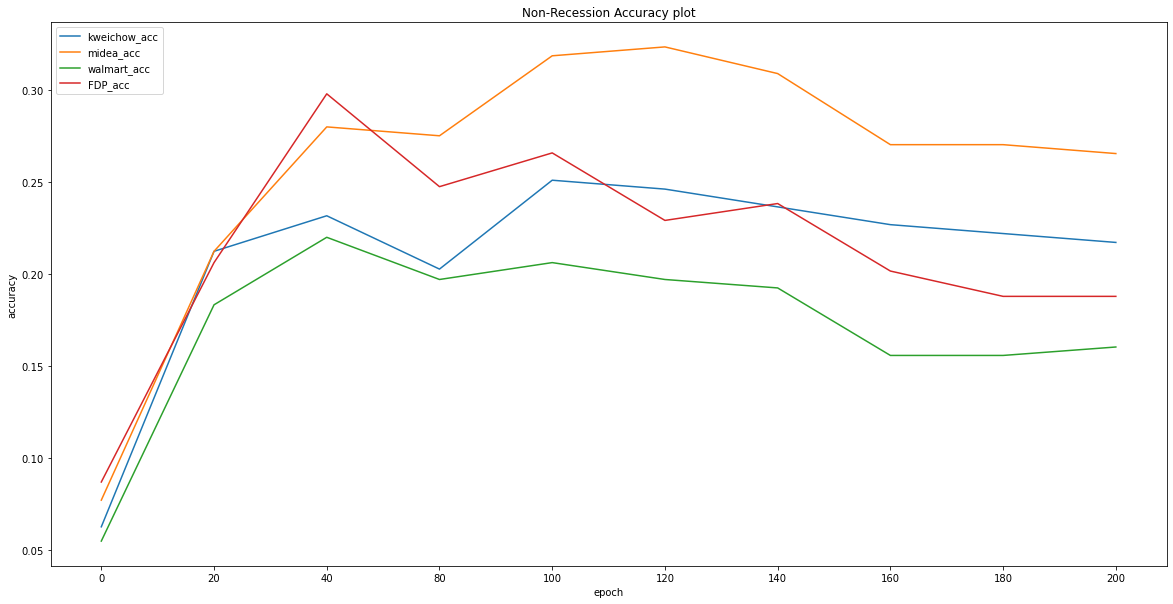

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

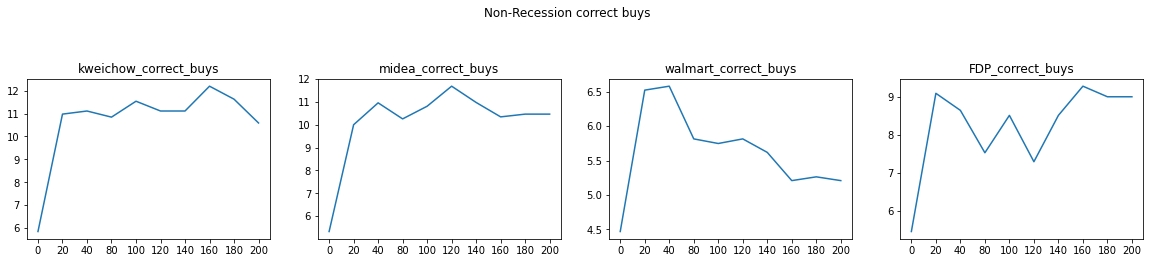

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

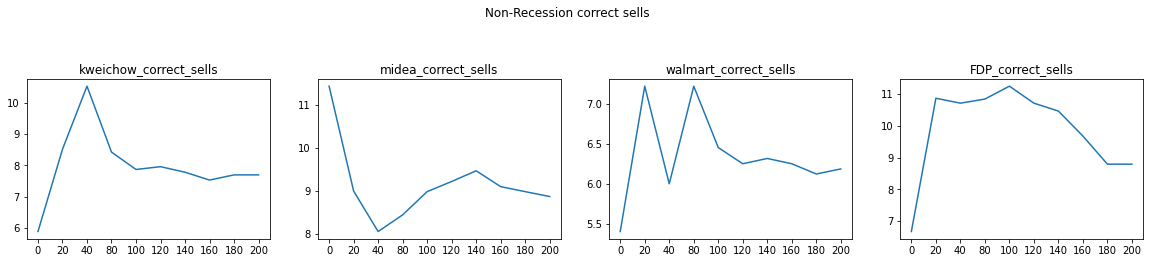

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

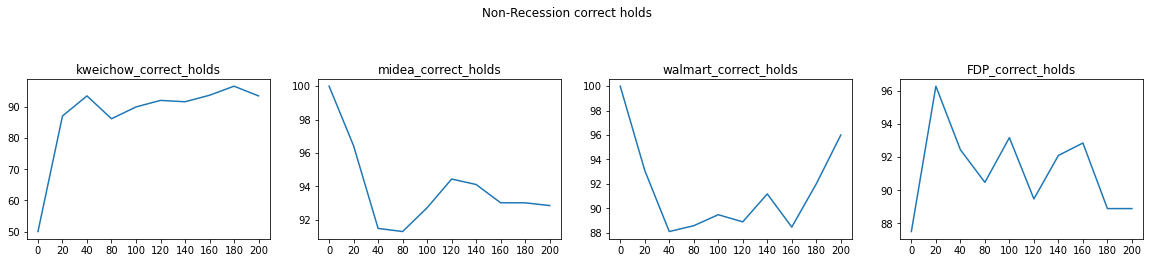

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

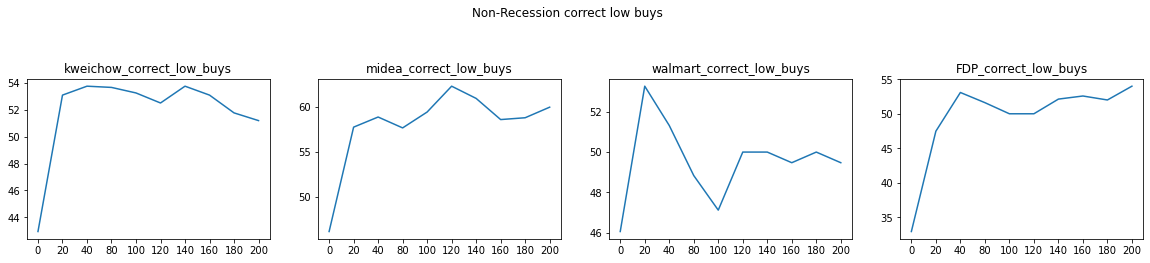

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

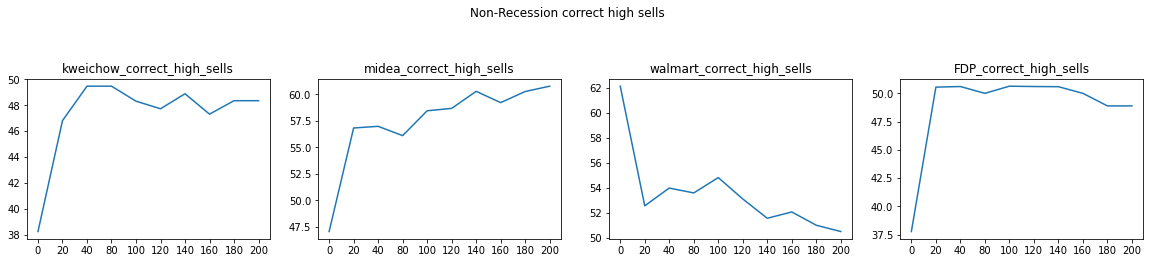

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

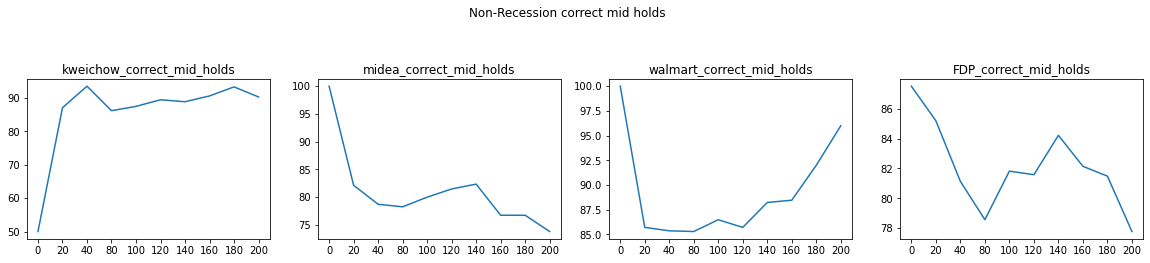

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

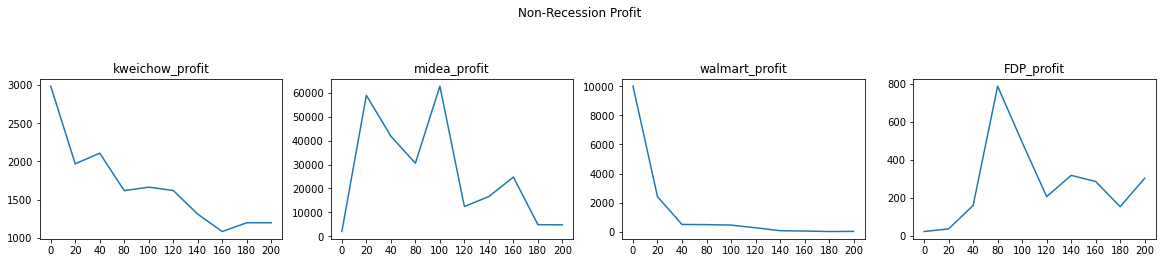

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")

In [30]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 
    
    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3]) 

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


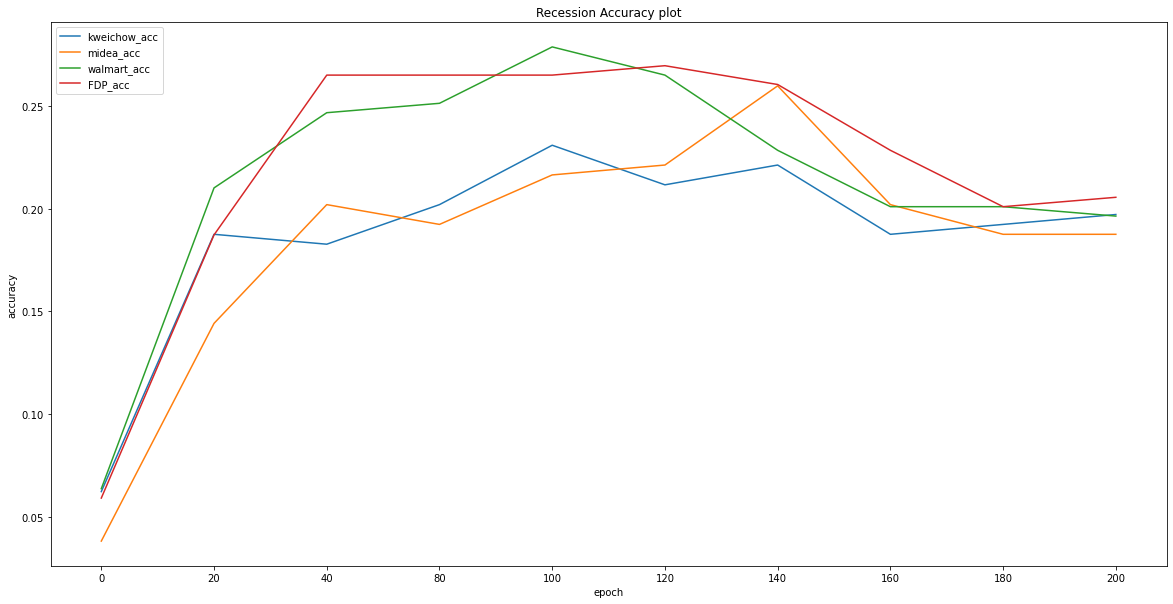

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

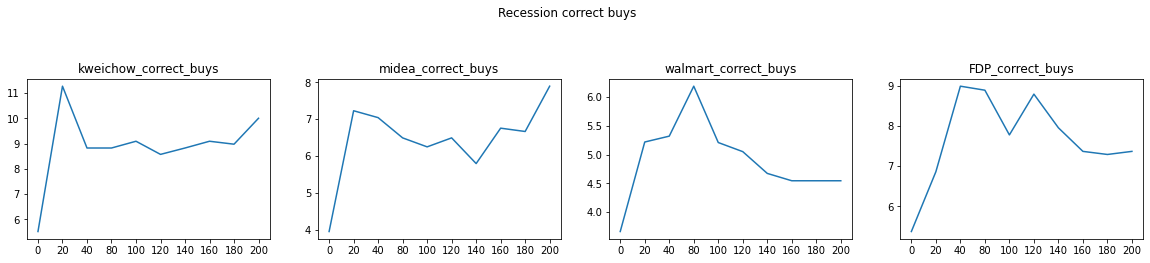

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

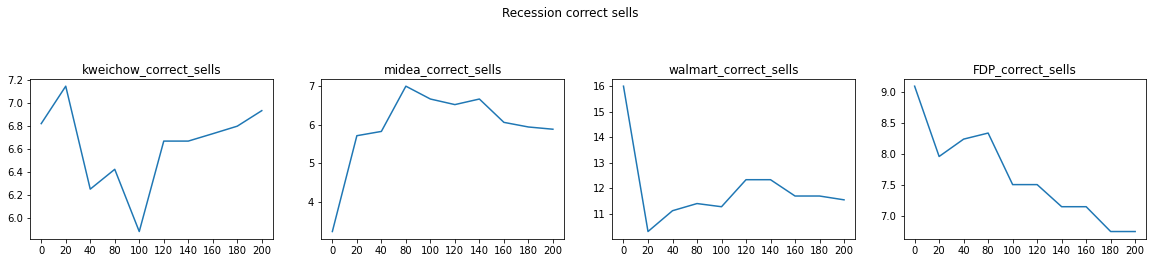

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

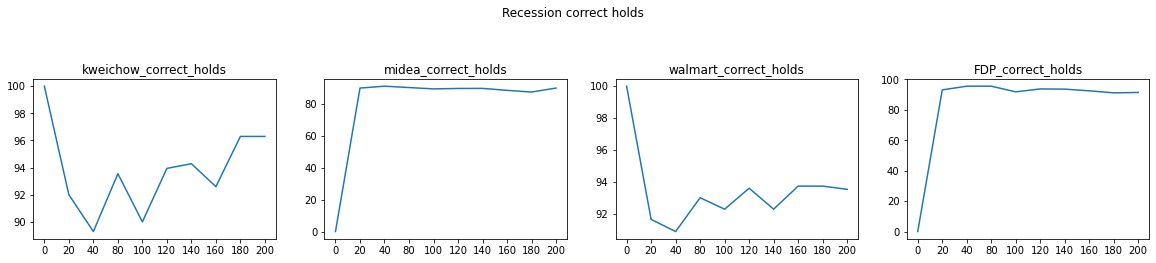

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

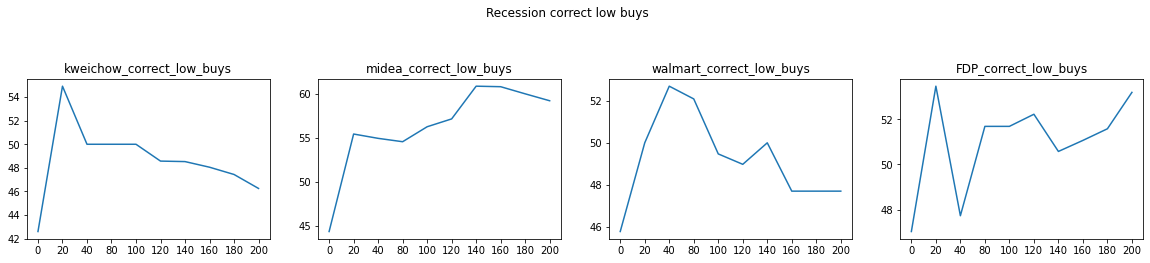

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

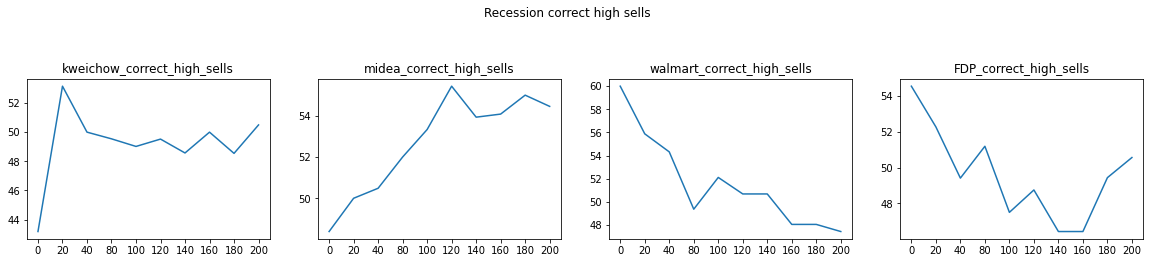

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

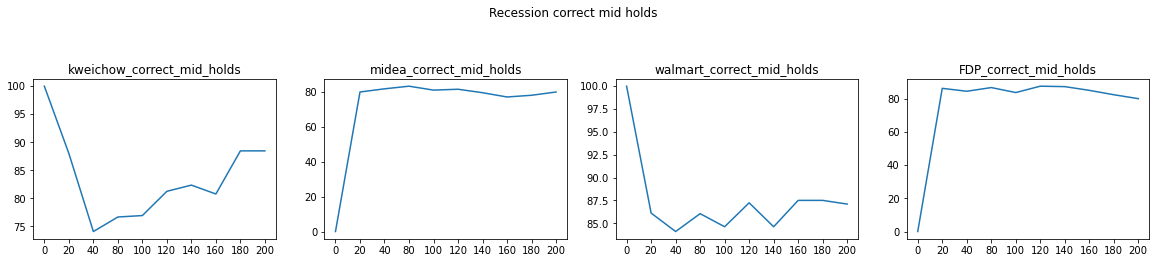

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

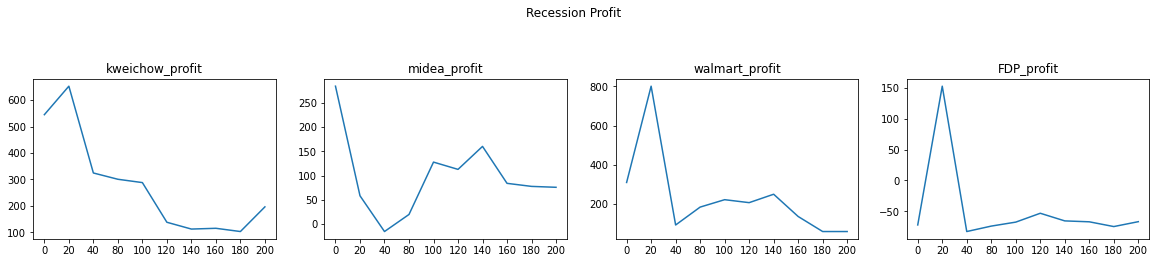

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")